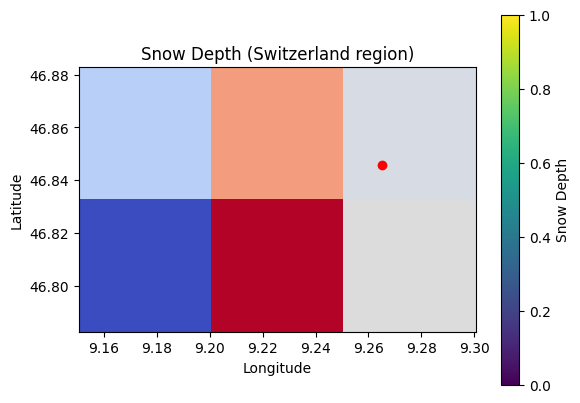

In [4]:
import rasterio
from rasterio.windows import from_bounds
import matplotlib.pyplot as plt

# Path to your GeoTIFF
tif_path = "EC-Earth3-Veg-LR_future/snd_LImon_EC-Earth3-Veg-LR_ssp245_r1i1p1f1_gr209802.tif"

# Laax bounding box (lon_min, lat_min, lon_max, lat_max)
center = (46.846, 9.265)
bbox = (9.1506, 46.8015, 9.2876, 46.8827)

# Open and clip raster
with rasterio.open(tif_path) as src:
    window = from_bounds(*bbox, transform=src.transform)
    data = src.read(1, window=window)
    transform = src.window_transform(window)

# Get spatial extent for plotting (left, right, bottom, top)
left, top = transform * (0, 0)
right, bottom = transform * (data.shape[1], data.shape[0])
extent = [left, right, bottom, top]

# Plot
plt.imshow(data, cmap="coolwarm", extent=extent, origin="upper")
plt.scatter(center[1], center[0], color="red", label="Laax", zorder=2)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Snow Depth (Switzerland region)")
plt.colorbar(label="Snow Depth")
plt.show()

# Snow Depth NetCDF Validation

This notebook checks that your new NetCDF contains the expected dimensions, coordinates, and data, including the **model**, **scenario**, and **realization** metadata you added.


In [1]:
# Cell 1: Imports & open dataset
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# Adjust path if needed
nc_file = "snow_depth_prediction.nc"
ds = xr.open_dataset(nc_file)
ds


<xarray.Dataset> Size: 55kB
Dimensions:      (time: 1376, latitude: 2, longitude: 3)
Coordinates:
    scenario     (time) object 11kB ...
  * time         (time) datetime64[ns] 11kB 2015-01-01 2015-02-01 ... 2100-12-01
    model        object 8B ...
    realization  object 8B ...
  * longitude    (longitude) float64 24B 9.151 9.201 9.251
  * latitude     (latitude) float64 16B 46.88 46.83
Data variables:
    snow_depth   (time, latitude, longitude) float32 33kB ...

In [2]:
# Cell 2: Inspect dimensions and coords
print("Dimensions:", ds.dims)
print("Coordinates on each dimension:")
for dim in ds.dims:
    print(f"  {dim}: {list(ds.coords[dim].values)[:3]} ... {list(ds.coords[dim].values)[-3:]}")
print("\nExtra coords on 'time':", [c for c in ds.coords if c not in ds.dims])


Dimensions: FrozenMappingWarningOnValuesAccess({'time': 1376, 'latitude': 2, 'longitude': 3})
Coordinates on each dimension:
  time: [numpy.datetime64('2015-01-01T00:00:00.000000000'), numpy.datetime64('2015-02-01T00:00:00.000000000'), numpy.datetime64('2015-03-01T00:00:00.000000000')] ... [numpy.datetime64('2100-02-01T00:00:00.000000000'), numpy.datetime64('2100-03-01T00:00:00.000000000'), numpy.datetime64('2100-12-01T00:00:00.000000000')]
  latitude: [46.88269999999999, 46.832699999999996] ... [46.88269999999999, 46.832699999999996]
  longitude: [9.150600000000026, 9.200600000000026, 9.250600000000025] ... [9.150600000000026, 9.200600000000026, 9.250600000000025]

Extra coords on 'time': ['scenario', 'model', 'realization']


In [3]:
# Cell 3: Unique models, scenarios, realizations
print("Models:", np.unique(ds.model.values))
print("Scenarios:", np.unique(ds.scenario.values))
print("Realizations:", np.unique(ds.realization.values))


Models: ['IPSL-CM6A-LR']
Scenarios: ['ssp126' 'ssp245' 'ssp370' 'ssp585']
Realizations: ['r1i1p1f1']


In [4]:
# Cell 4: Time and spatial ranges
print("Time range: ", ds.time.min().values, "→", ds.time.max().values)
print("Latitude range:", float(ds.latitude.min()), "→", float(ds.latitude.max()))
print("Longitude range:", float(ds.longitude.min()), "→", float(ds.longitude.max()))


Time range:  2015-01-01T00:00:00.000000000 → 2100-12-01T00:00:00.000000000
Latitude range: 46.832699999999996 → 46.88269999999999
Longitude range: 9.150600000000026 → 9.250600000000025


In [5]:
# Cell 5: Data integrity stats
sd = ds["snow_depth"]
print("Snow depth stats (min, mean, max):",
      float(np.nanmin(sd)), float(np.nanmean(sd)), float(np.nanmax(sd)))
print("Count of missing (NaN) values:", int(np.isnan(sd).sum()))


Snow depth stats (min, mean, max): 0.006805425975471735 0.6233431100845337 1.41056227684021
Count of missing (NaN) values: 0


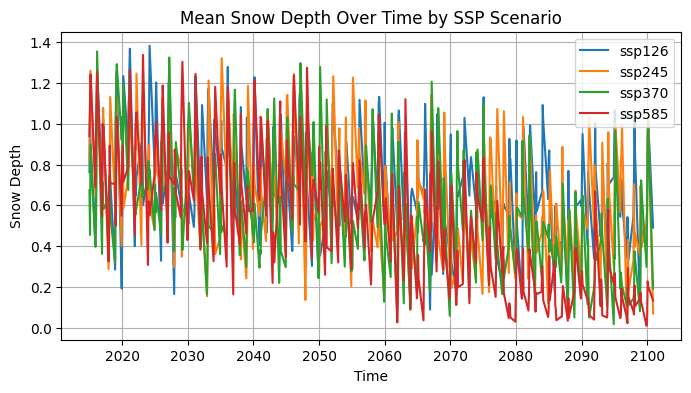

In [6]:
# Cell 6: Mean time-series by scenario
plt.figure(figsize=(8,4))

for scen, group in sd.groupby("scenario"):
    ts = group.mean(dim=("latitude", "longitude"))
    ts.plot(label=scen)

plt.title("Mean Snow Depth Over Time by SSP Scenario")
plt.ylabel("Snow Depth")
plt.xlabel("Time")
plt.legend()
plt.grid(True)
plt.show()


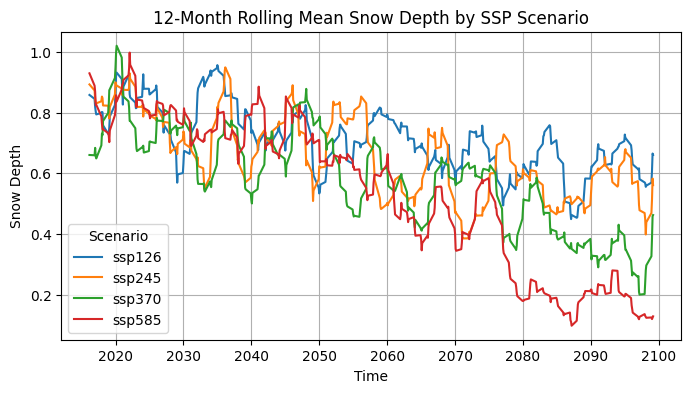

In [7]:
# Cell 6: 12-month Rolling Mean Snow Depth by SSP Scenario
plt.figure(figsize=(8, 4))
window = 12  # rolling window in months

for scen, group in sd.groupby("scenario"):
    # compute spatial mean time series
    ts = group.mean(dim=("latitude", "longitude"))
    # compute centered rolling mean
    ts_rolling = ts.rolling(time=window, center=True).mean()
    ts_rolling.plot(label=scen)

plt.title(f"{window}-Month Rolling Mean Snow Depth by SSP Scenario")
plt.ylabel("Snow Depth")
plt.xlabel("Time")
plt.legend(title="Scenario")
plt.grid(True)
plt.show()


In [9]:
# Am Anfang der Funktion main() nach dem Laden des Datasets:
st.write("Dimensionen:", ds.dims)
st.write("Koordinaten:", list(ds.coords))
st.write("Datenstruktur:", ds.snow_depth.shape)
if 'scenario' in ds:
    unique_scenarios = np.unique(ds.scenario.values)
    st.write("Szenarien:", unique_scenarios)
time_df = pd.DataFrame({'time': ds.time.values})
st.write("Zeitstempel-Analyse:", time_df.value_counts().head())

NameError: name 'st' is not defined

In [10]:
import xarray as xr
import pandas as pd
import numpy as np

# Dataset öffnen
nc_file = "snow_depth_prediction.nc"
ds = xr.open_dataset(nc_file)

# Grundlegende Informationen
print("Dataset Info:")
print(f"Dimensionen: {ds.dims}")
print(f"Variablen: {list(ds.data_vars)}")
print(f"Koordinaten: {list(ds.coords)}")

# Prüfen, ob Zeitstempel eindeutig sind
time_values = ds.time.values
unique_times = np.unique(time_values)
print(f"\nZeitstempel insgesamt: {len(time_values)}")
print(f"Eindeutige Zeitstempel: {len(unique_times)}")
print(f"Duplikate: {len(time_values) - len(unique_times)}")

# Detaillierte Analyse der Zeitdimension
print("\nStruktur der Zeitdimension:")
if len(time_values) != len(unique_times):
    time_df = pd.DataFrame({'time': time_values})
    duplicates = time_df['time'].value_counts()
    print("Anzahl der Vorkommen pro Zeitstempel (Top 10):")
    print(duplicates.head(10))
    
    # Beispiel für doppelte Zeitstempel
    duplicate_example = time_df['time'].value_counts().index[0]
    print(f"\nBeispiel für einen mehrfach auftretenden Zeitstempel: {duplicate_example}")
    
    # Was macht diesen Zeitstempel besonders?
    example_data = ds.sel(time=duplicate_example)
    print("\nDaten für diesen Zeitstempel:")
    if 'scenario' in ds.coords:
        print(f"Szenarien: {example_data.scenario.values}")
    
# Überprüfen, welche anderen Dimensionen mit dem Zeitstempel verbunden sind
print("\nStrukturanalyse für Zeitabhängigkeiten:")
for coord in ds.coords:
    if coord != 'time' and ds[coord].dims == ('time',):
        print(f"Koordinate '{coord}' ist zeitabhängig")
        # Überprüfen, ob für jeden doppelten Zeitstempel unterschiedliche Werte existieren
        if len(time_values) != len(unique_times):
            first_duplicate = time_df['time'].value_counts().index[0]
            duplicate_values = ds.sel(time=first_duplicate)[coord].values
            print(f"  Werte für den ersten doppelten Zeitstempel: {duplicate_values}")

# Snow depth Datenstruktur
print("\nSnow Depth Datenstruktur:")
print(f"Form: {ds.snow_depth.shape}")
print(f"Dimensionen: {ds.snow_depth.dims}")

# Datenstichprobe für einen bestimmten Zeitpunkt und ein bestimmtes Szenario
if 'scenario' in ds.coords:
    scenario = ds.scenario.values[0]
    timepoint = ds.time.values[0]
    print(f"\nStichprobe für Zeitpunkt {timepoint} und Szenario {scenario}:")
    sample = ds.snow_depth.sel(time=timepoint, scenario=scenario)
    print(sample.values)

Dataset Info:
Dimensionen: FrozenMappingWarningOnValuesAccess({'time': 1376, 'latitude': 2, 'longitude': 3})
Variablen: ['snow_depth']
Koordinaten: ['scenario', 'time', 'model', 'realization', 'longitude', 'latitude']

Zeitstempel insgesamt: 1376
Eindeutige Zeitstempel: 344
Duplikate: 1032

Struktur der Zeitdimension:
Anzahl der Vorkommen pro Zeitstempel (Top 10):
time
2015-01-01    4
2071-03-01    4
2073-03-01    4
2073-02-01    4
2073-01-01    4
2072-12-01    4
2072-03-01    4
2072-02-01    4
2072-01-01    4
2071-12-01    4
Name: count, dtype: int64

Beispiel für einen mehrfach auftretenden Zeitstempel: 2015-01-01 00:00:00

Daten für diesen Zeitstempel:


AttributeError: 'DataArray' object has no attribute 'values'